开始仿真波束插值...
Ratio A:B       | Peak Angle      | Peak Gain (dB) 
--------------------------------------------------
1.00 : 0.00    |  14.50°       |  -0.00 dB
0.99 : 0.16    |  15.59°       |  -0.09 dB
0.95 : 0.31    |  16.67°       |  -0.35 dB
0.89 : 0.45    |  17.75°       |  -0.81 dB
0.81 : 0.59    |  18.83°       |  -1.48 dB
0.71 : 0.71    |  20.09°       |  -2.38 dB
0.59 : 0.81    | -18.83°       |  -1.48 dB
0.45 : 0.89    | -17.75°       |  -0.81 dB
0.31 : 0.95    | -16.67°       |  -0.35 dB
0.16 : 0.99    | -15.59°       |  -0.09 dB
0.00 : 1.00    | -14.50°       |  -0.00 dB


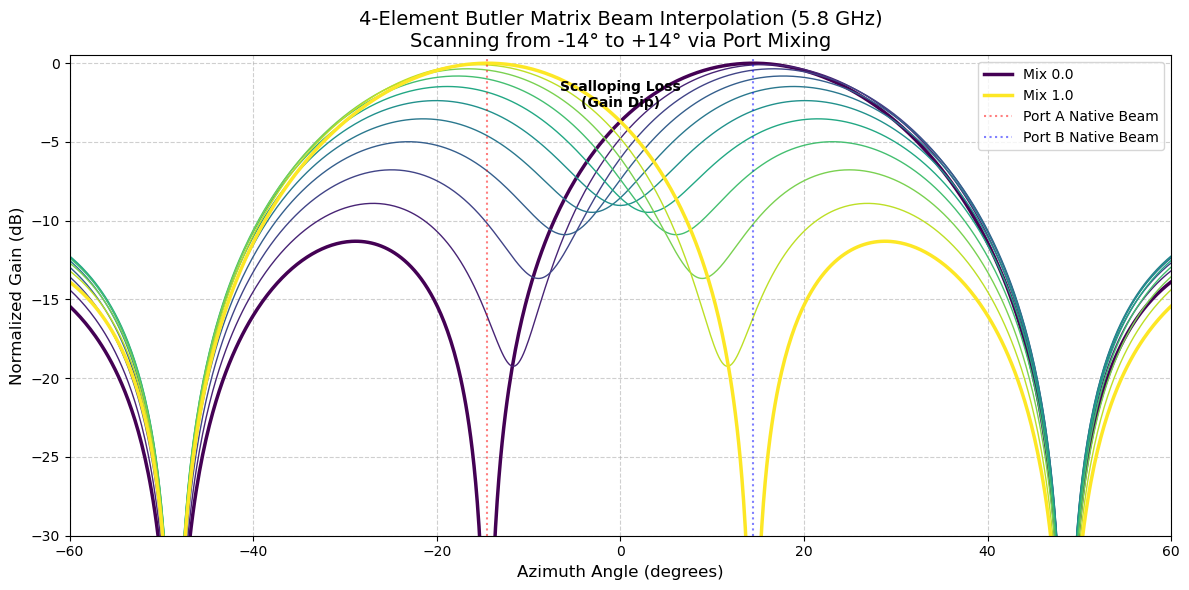

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# ==========================================
# 1. 物理参数设置
# ==========================================
FREQ = 5.8e9             # 频率: 5.8 GHz
C = 3e8                  # 光速
LAMBDA = C / FREQ        # 波长
N_ELEMENTS = 4           # 阵元数量 (4x4 巴特勒矩阵)
SPACING = LAMBDA / 2     # 阵元间距 (半波长)
K = 2 * np.pi / LAMBDA   # 波数

# ==========================================
# 2. 巴特勒矩阵的相位逻辑
# ==========================================
# 标准 4x4 巴特勒矩阵产生 4 个相位梯度，对应 4 个波束。
# 这里我们选取两个相邻的波束进行插值演示：
# Beam 1 (1L): 阵元间相位差 beta = -45度 (指向右侧约 14度)
# Beam 2 (2R): 阵元间相位差 beta = +45度 (指向左侧约 -14度)

# 定义阵元位置 (0, d, 2d, 3d)
element_positions = np.arange(N_ELEMENTS) * SPACING

# 定义两个端口产生的复数权重 (Phasors)
# 端口 A 的相位梯度: -45度 (-pi/4)
beta_a = -np.pi / 4
weights_a = np.exp(1j * beta_a * np.arange(N_ELEMENTS))

# 端口 B 的相位梯度: +45度 (+pi/4)
beta_b = np.pi / 4
weights_b = np.exp(1j * beta_b * np.arange(N_ELEMENTS))

# ==========================================
# 3. 核心计算函数：阵列因子 (Array Factor)
# ==========================================
def calculate_array_factor(weights, theta_range):
    """
    计算远场方向图
    weights: 各阵元的复数激励 (Current/Voltage)
    theta_range: 扫描角度范围 (弧度)
    """
    af = np.zeros_like(theta_range, dtype=complex)
    # 叠加所有阵元的贡献: A * exp(j * (k * d * sin(theta) + phase))
    for n in range(N_ELEMENTS):
        spatial_phase = K * element_positions[n] * np.sin(theta_range)
        af += weights[n] * np.exp(1j * spatial_phase)
    
    # 归一化并转为 dB
    af_mag = np.abs(af)
    af_mag_norm = af_mag / N_ELEMENTS # 归一化到最大值为 1 (0dB)
    # 防止 log(0)
    af_db = 20 * np.log10(np.clip(af_mag_norm, 1e-5, 1.0)) 
    return af_db

# ==========================================
# 4. 仿真循环：波束插值扫描
# ==========================================
# 扫描角度范围 (-90度 到 90度)
theta_deg = np.linspace(-90, 90, 1000)
theta_rad = np.deg2rad(theta_deg)

plt.figure(figsize=(12, 6))

# 设置混合比例 (Mixing Ratio) 从 0 (全A) 到 1 (全B)
# 使用 sin/cos 混合以保持总功率恒定 (Power Constant)
steps = 11
ratios = np.linspace(0, 1, steps)
colors = cm.viridis(np.linspace(0, 1, steps))

print("开始仿真波束插值...")
print(f"{'Ratio A:B':<15} | {'Peak Angle':<15} | {'Peak Gain (dB)':<15}")
print("-" * 50)

for i, r in enumerate(ratios):
    # 功率恒定插值算法
    amp_a = np.cos(r * np.pi / 2)
    amp_b = np.sin(r * np.pi / 2)
    
    # 两个端口同时馈电 -> 矢量叠加 (Superposition)
    # 关键点：这里模拟的是巴特勒矩阵前端有一个可变功分器
    combined_weights = amp_a * weights_a + amp_b * weights_b
    
    # 计算方向图
    af_db = calculate_array_factor(combined_weights, theta_rad)
    
    # 找到峰值位置
    peak_idx = np.argmax(af_db)
    peak_angle = theta_deg[peak_idx]
    peak_gain = af_db[peak_idx]
    
    print(f"{amp_a:.2f} : {amp_b:.2f}    | {peak_angle:6.2f}°       | {peak_gain:6.2f} dB")
    
    # 绘图
    label = f"Mix {r:.1f}" if i == 0 or i == steps-1 else None
    linewidth = 2.5 if i == 0 or i == steps-1 else 1.0
    plt.plot(theta_deg, af_db, color=colors[i], label=label, linewidth=linewidth)

# ==========================================
# 5. 图表美化
# ==========================================
plt.title(f'4-Element Butler Matrix Beam Interpolation (5.8 GHz)\nScanning from -14° to +14° via Port Mixing', fontsize=14)
plt.xlabel('Azimuth Angle (degrees)', fontsize=12)
plt.ylabel('Normalized Gain (dB)', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.ylim(-30, 0.5) # 只看主瓣和第一旁瓣
plt.xlim(-60, 60)

# 标注关键区域
plt.axvline(x=-14.5, color='r', linestyle=':', alpha=0.5, label='Port A Native Beam')
plt.axvline(x=14.5, color='b', linestyle=':', alpha=0.5, label='Port B Native Beam')
plt.text(0, -3, 'Scalloping Loss\n(Gain Dip)', ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

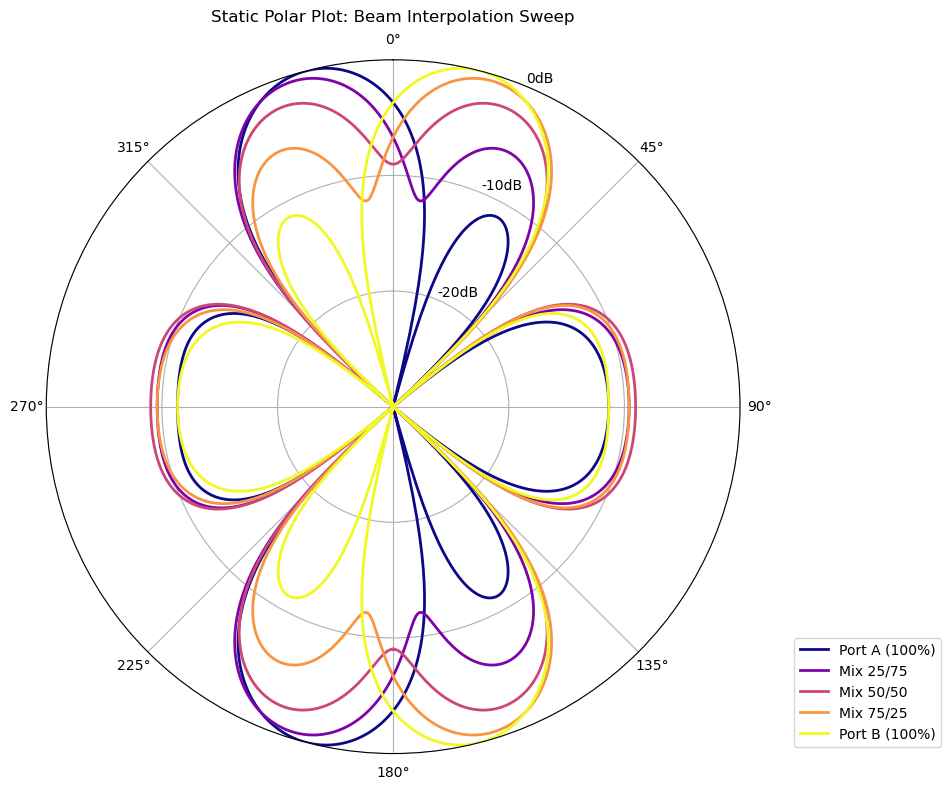

正在生成动画，请稍候...
动画已保存为 'beam_scanning.gif'


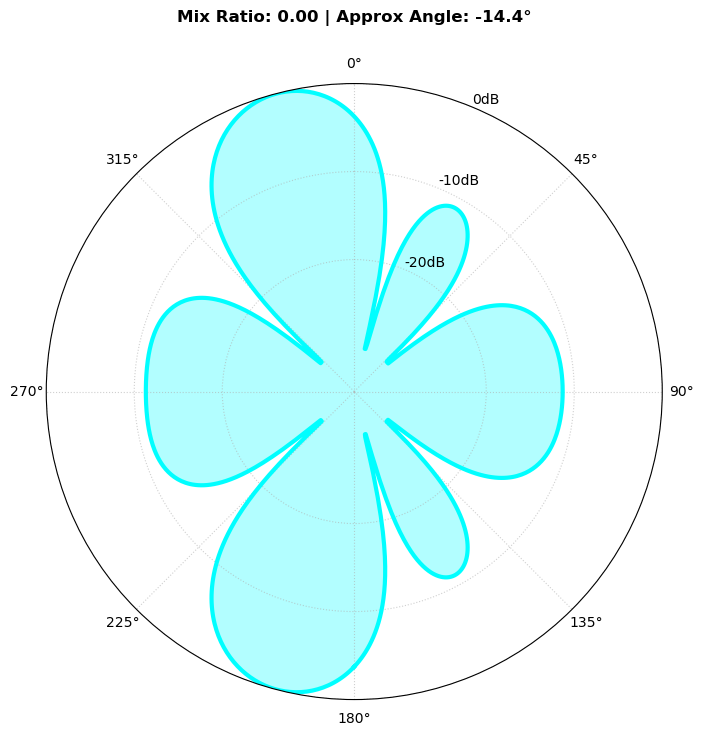

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm

# ==========================================
# 1. 物理参数定义
# ==========================================
FREQ = 5.8e9
LAMBDA = 3e8 / FREQ
N_ELEMENTS = 4
SPACING = LAMBDA / 2
K = 2 * np.pi / LAMBDA

# 阵元位置
element_positions = np.arange(N_ELEMENTS) * SPACING

# 定义两个基础波束的相位梯度 (Butler Matrix 两个相邻端口)
# Beam A (左偏): +45度相位差
weights_a = np.exp(1j * (np.pi/4) * np.arange(N_ELEMENTS))
# Beam B (右偏): -45度相位差
weights_b = np.exp(1j * (-np.pi/4) * np.arange(N_ELEMENTS))

# 扫描角度范围 (0度在正北方)
theta_deg = np.linspace(-180, 180, 720)
theta_rad = np.deg2rad(theta_deg)

def get_af_db(mix_ratio):
    """
    计算特定混合比例下的阵列因子(dB)
    mix_ratio: 0.0 (全A) -> 1.0 (全B)
    """
    # 使用恒定功率混合 (Constant Power Mixing)
    amp_a = np.cos(mix_ratio * np.pi / 2)
    amp_b = np.sin(mix_ratio * np.pi / 2)
    
    # 矢量叠加
    w_total = amp_a * weights_a + amp_b * weights_b
    
    # 计算阵列因子
    af = np.zeros_like(theta_rad, dtype=complex)
    for n in range(N_ELEMENTS):
        # 注意：极坐标绘图中，通常定义 theta 为方位角
        phase_space = K * element_positions[n] * np.sin(theta_rad)
        af += w_total[n] * np.exp(1j * phase_space)
    
    # 归一化并转 dB
    af_mag = np.abs(af) / N_ELEMENTS
    af_db = 20 * np.log10(np.clip(af_mag, 1e-4, 1.0))
    
    # 为了极坐标显示好看，截断底部噪音，只看 -30dB 以上
    floor_db = -30
    af_db = np.clip(af_db, floor_db, 0)
    return af_db

# ==========================================
# 2. 生成静态极坐标图 (Static Polar Plot)
# ==========================================
def plot_static_polar():
    fig = plt.figure(figsize=(10, 8))
    ax = plt.subplot(111, projection='polar')
    
    # 设置极坐标方向：0度(正北)朝上，顺时针旋转
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    
    # 绘制几个关键状态
    ratios = [0.0, 0.25, 0.5, 0.75, 1.0]
    labels = ["Port A (100%)", "Mix 25/75", "Mix 50/50", "Mix 75/25", "Port B (100%)"]
    colors = cm.plasma(np.linspace(0, 1, len(ratios)))
    
    for r, col, lab in zip(ratios, colors, labels):
        r_data = get_af_db(r)
        # 极坐标图的半径通常需要是正数，所以我们把 dB 加上一个偏置
        # 例如：0dB -> 半径30, -30dB -> 半径0
        r_plot = r_data + 30 
        ax.plot(theta_rad, r_plot, color=col, linewidth=2, label=lab)

    # 美化网格
    ax.set_rmin(0)
    ax.set_rmax(30)
    ax.set_rticks([10, 20, 30]) 
    ax.set_yticklabels(['-20dB', '-10dB', '0dB'])
    ax.set_title("Static Polar Plot: Beam Interpolation Sweep", va='bottom')
    ax.legend(loc='lower right', bbox_to_anchor=(1.3, 0.0))
    plt.tight_layout()
    plt.show()

# ==========================================
# 3. 生成动画 (Animation)
# ==========================================
def create_animation():
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, projection='polar')
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    
    # 初始化线条
    line, = ax.plot([], [], color='cyan', linewidth=3)
    fill = ax.fill([], [], color='cyan', alpha=0.3)[0] # 填充颜色
    
    # 美化刻度
    ax.set_rmin(0)
    ax.set_rmax(35) #稍微留点余量
    ax.set_rticks([15, 25, 35])
    ax.set_yticklabels(['-20dB', '-10dB', '0dB'])
    ax.grid(True, linestyle=':', alpha=0.6)
    
    title_text = ax.text(0, 42, "", ha='center', fontsize=12, fontweight='bold')

    # 动画更新函数
    def update(frame):
        # 生成 0 -> 1 -> 0 的往复运动 (三角波)
        t = frame / 50.0 
        ratio = 0.5 * (1 + np.sin(2 * np.pi * t - np.pi/2)) # 平滑的正弦扫描
        
        af_db = get_af_db(ratio)
        r_plot = af_db + 35 # 偏置，让 -35dB 为圆心
        
        # 更新线条数据
        line.set_data(theta_rad, r_plot)
        
        # 更新填充区域 (极坐标填充需要一点技巧，重置 vertices)
        # 这是一个简单的 workaround 来更新 fill
        path = line.get_path()
        fill.get_path().vertices = path.vertices
        fill.get_path().codes = path.codes
        
        # 动态改变颜色指示混合状态
        line.set_color(cm.cool(ratio))
        fill.set_facecolor(cm.cool(ratio))
        fill.set_alpha(0.3)
        
        # 更新标题
        scan_angle = -14.5 + ratio * 29 # 估算角度
        title_text.set_text(f"Mix Ratio: {ratio:.2f} | Approx Angle: {scan_angle:.1f}°")
        return line, fill, title_text

    print("正在生成动画，请稍候...")
    # 创建动画: 100帧，间隔50ms
    ani = animation.FuncAnimation(fig, update, frames=np.arange(0, 50), interval=50, blit=False)
    
    # 保存为 GIF
    ani.save('beam_scanning.gif', writer='pillow', fps=20)
    print("动画已保存为 'beam_scanning.gif'")
    plt.show()

if __name__ == "__main__":
    # 先看静态图
    plot_static_polar()
    
    # 再生成动画
    create_animation()

=== 2.4 GHz 微带贴片单元设计参数 ===
基板材料: Er=4.4, 厚度=1.6mm
------------------------------
1. 贴片宽度 (W):  38.01 mm
2. 贴片长度 (L):  29.42 mm
3. 馈电点深度 (y0): 10.82 mm (从边缘向内凹进)
4. 推荐地平面尺寸: 至少 48 x 39 mm
------------------------------


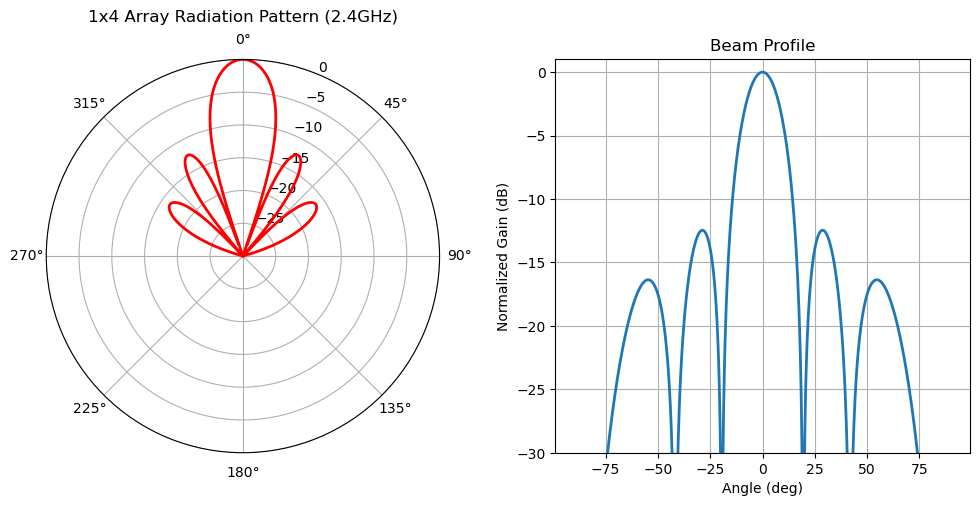

阵列总长度估算: 319.1 mm


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c, pi

class PatchAntennaDesigner:
    def __init__(self, freq_hz, dielectric_constant, height_mm, loss_tangent=0.02):
        """
        初始化微带天线设计器
        :param freq_hz: 工作频率 (Hz)
        :param dielectric_constant: 板材介电常数 (FR4=4.4, Rogers4350=3.66)
        :param height_mm: 板材厚度 (mm)
        """
        self.f0 = freq_hz
        self.er = dielectric_constant
        self.h = height_mm / 1000.0 # 转为米
        self.tand = loss_tangent
        
    def calculate_dimensions(self):
        """
        根据传输线模型计算贴片物理尺寸
        """
        # 1. 计算宽度 W (Width)
        # 宽度的选择主要影响辐射效率和带宽
        w = (c / (2 * self.f0)) * np.sqrt(2 / (self.er + 1))
        
        # 2. 计算有效介电常数 (Effective Dielectric Constant)
        # 考虑边缘场效应，微带线的有效er比基板er小
        eeff = (self.er + 1) / 2 + (self.er - 1) / 2 * (1 + 12 * self.h / w) ** -0.5
        
        # 3. 计算等效长度延伸量 (Length Extension, dl)
        # 电场在边缘会溢出，导致电长度比物理长度长
        dl = 0.412 * self.h * (eeff + 0.3) * (w / self.h + 0.264) / \
             ((eeff - 0.258) * (w / self.h + 0.8))
             
        # 4. 计算实际物理长度 L (Length)
        # L_eff = c / (2 * f * sqrt(eeff))
        # L = L_eff - 2 * dl
        l_eff = c / (2 * self.f0 * np.sqrt(eeff))
        l = l_eff - 2 * dl
        
        # 5. 计算 50欧姆 嵌入馈电点深度 (Inset Feed Depth, y0)
        # 贴片边缘阻抗通常在 200-400欧姆，需向内凹进以匹配 50欧姆
        # 这是一个近似公式
        R_in = 90 * (self.er ** 2) / (self.er - 1) * (l / w) ** 2 # 边缘阻抗估算
        y0 = (l / pi) * np.arccos(np.sqrt(50 / R_in))
        
        return {
            "W": w * 1000,      # mm
            "L": l * 1000,      # mm
            "h": self.h * 1000, # mm
            "dL": dl * 1000,    # mm
            "Inset_y0": y0 * 1000, # mm (从边缘向中心的距离)
            "Feed_Width": 3.0 * self.h * 1000 # 50欧姆微带线的大致宽度(粗略值)
        }

    def simulate_1x4_array(self, patch_w_mm, spacing_ratio=0.75):
        """
        模拟 1x4 阵列的方向图
        :param spacing_ratio: 单元间距与波长的比例 (通常 0.5 - 0.8)
        """
        lambda_0 = c / self.f0
        d = spacing_ratio * lambda_0
        k = 2 * pi / lambda_0
        
        theta = np.linspace(-pi/2, pi/2, 1000) # 扫描角度 -90 到 90
        
        # 1. 单元因子 (Element Pattern) - 近似为余弦函数
        # 微带贴片的E面方向图近似为 cos(theta)
        element_pattern = np.cos(theta)
        
        # 2. 阵列因子 (Array Factor)
        # AF = sum( exp(j * (n * k * d * sin(theta) + beta)) )
        # 这里设 beta=0 (侧射阵，波束指向正前方)
        N = 4
        af = np.zeros_like(theta, dtype=complex)
        for n in range(N):
            # 阵列中心对齐
            pos = (n - (N-1)/2) * d
            af += np.exp(1j * k * pos * np.sin(theta))
            
        # 3. 总方向图 = 单元因子 * 阵列因子
        total_field = np.abs(element_pattern * af)
        
        # 归一化并转 dB
        total_db = 20 * np.log10(total_field / np.max(total_field))
        total_db = np.clip(total_db, -40, 0) # 截断底部噪音
        
        return theta, total_db, d

# ==========================================
# 主程序：设计与输出
# ==========================================

# 1. 设置参数 (针对常见的 PCB 材料)
# 推荐使用 Rogers 4350B (Er=3.66) 以获得更好性能
# 如果为了便宜用 FR4 (Er=4.4)，效率会低一些
FREQ = 2.4e9  # 2.4 GHz
ER = 4.4      # FR4 介电常数
H = 1.6       # 板厚 1.6mm

designer = PatchAntennaDesigner(FREQ, ER, H)
dims = designer.calculate_dimensions()

# 2. 输出 CAD 尺寸
print(f"=== {FREQ/1e9} GHz 微带贴片单元设计参数 ===")
print(f"基板材料: Er={ER}, 厚度={H}mm")
print("-" * 30)
print(f"1. 贴片宽度 (W):  {dims['W']:.2f} mm")
print(f"2. 贴片长度 (L):  {dims['L']:.2f} mm")
print(f"3. 馈电点深度 (y0): {dims['Inset_y0']:.2f} mm (从边缘向内凹进)")
print(f"4. 推荐地平面尺寸: 至少 {dims['W']+6*H:.0f} x {dims['L']+6*H:.0f} mm")
print("-" * 30)

# 3. 仿真 1x4 阵列
# 间距通常取 0.75 波长以获得高增益且无栅瓣
theta, pattern_db, spacing = designer.simulate_1x4_array(dims['W'], spacing_ratio=0.75)

# 4. 绘图
plt.figure(figsize=(10, 5))

# 极坐标图
ax1 = plt.subplot(121, projection='polar')
ax1.plot(theta, pattern_db, color='r', linewidth=2)
ax1.set_theta_zero_location("N") # 0度朝上
ax1.set_theta_direction(-1)      # 顺时针
ax1.set_title("1x4 Array Radiation Pattern (2.4GHz)", va='bottom')
ax1.set_rmin(-30)
ax1.set_rmax(0)
ax1.grid(True)

# 直角坐标图
ax2 = plt.subplot(122)
ax2.plot(np.rad2deg(theta), pattern_db, linewidth=2)
ax2.set_xlabel("Angle (deg)")
ax2.set_ylabel("Normalized Gain (dB)")
ax2.set_title("Beam Profile")
ax2.grid(True)
ax2.set_ylim(-30, 1)

# 标注主波束宽度
plt.tight_layout()
plt.show()

print(f"阵列总长度估算: {spacing*1000*3 + dims['W']:.1f} mm")

<>:188: SyntaxWarning: invalid escape sequence '\l'
<>:190: SyntaxWarning: invalid escape sequence '\l'
<>:188: SyntaxWarning: invalid escape sequence '\l'
<>:190: SyntaxWarning: invalid escape sequence '\l'
/var/folders/7c/kwhn06r91h57xlqx9rqvvpmm0000gn/T/ipykernel_57579/962394490.py:188: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(theta, total_db, label=f'd = {d_ratio:.2f}$\lambda$', linewidth=2)
/var/folders/7c/kwhn06r91h57xlqx9rqvvpmm0000gn/T/ipykernel_57579/962394490.py:190: SyntaxWarning: invalid escape sequence '\l'
  plt.title(f'Optimized 1x4 Array Pattern (d={d_ratio:.2f}$\lambda$)')


>>> 正在启动差分进化算法优化天线单元...

[单元优化结果]
频率: 2.4 GHz
最优长度 L : 31.960 mm
最优宽度 W : 59.886 mm
最优馈电点 y0: 9.146 mm (Inset Feed)
预测 VSWR: 1.0167 (含惩罚因子)

>>> 正在优化阵列间距...

[阵列优化结果]
最优间距比例: 0.801 * Lambda
物理间距 d: 100.07 mm


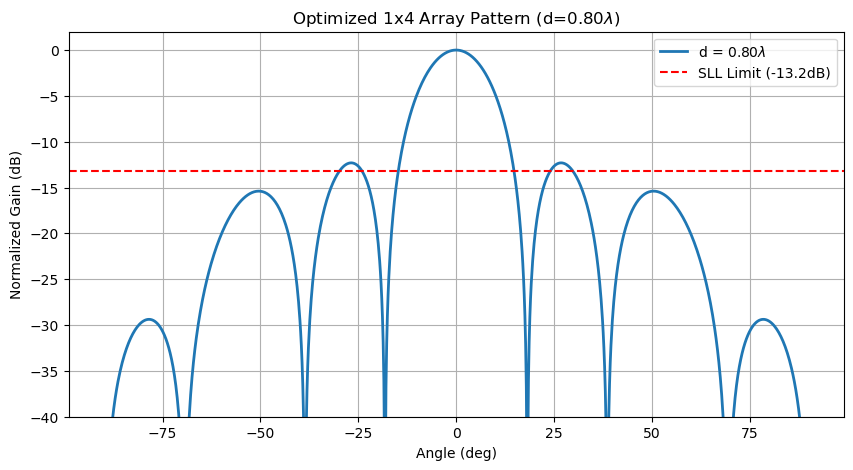

In [4]:
import numpy as np
from scipy.optimize import differential_evolution
from scipy.constants import c, pi
import matplotlib.pyplot as plt

class AntennaOptimizer:
    def __init__(self, target_freq, epsilon_r, h_mm, loss_tangent=0.02):
        self.f0 = target_freq
        self.er = epsilon_r
        self.h = h_mm / 1000.0
        self.tand = loss_tangent
        self.k0 = 2 * pi * target_freq / c
        
    def _calc_impedance(self, L, W, y0):
        """
        基于空腔模型计算微带天线的输入阻抗
        输入单位均为米
        """
        # 1. 宽度修正与辐射电导 G1 calculation
        # 这是一个简化的辐射电导公式
        k0 = self.k0
        G1 = (W / (120 * pi * c / self.f0)) * (1 - (k0*self.h)**2 / 24) # 近似
        if G1 == 0: G1 = 1e-9

        # 2. 有效介电常数
        eeff = (self.er + 1) / 2 + (self.er - 1) / 2 * (1 + 12 * self.h / W) ** -0.5
        
        # 3. 边缘延伸量 dL
        dl = 0.412 * self.h * (eeff + 0.3) * (W / self.h + 0.264) / \
             ((eeff - 0.258) * (W / self.h + 0.8))
             
        # 4. 有效长度
        Leff = L + 2 * dl
        
        # 5. 谐振频率下的边缘电阻 (R_edge)
        # R_edge = 1 / (2 * G1) 这是一个理想化近似
        # 更精确的工程近似：
        R_edge = 90 * (self.er**2 / (self.er - 1)) * (L/W)**2 
        
        # 6. 计算特定馈电点 y0 处的输入阻抗
        # Zin(y0) = R_edge * cos^2(pi * y0 / L)
        # 注意：这里我们主要关注实部匹配，忽略电抗部分(假定在谐振点电抗为0)
        # 实际优化中，长度 L 的微小变化就是在调电抗
        
        # 频率偏离带来的电抗 (简化模型)
        # 这是一个 heuristic，惩罚偏离谐振频率的设计
        f_calc = c / (2 * np.sqrt(eeff) * Leff)
        freq_error = abs(self.f0 - f_calc) / self.f0
        
        R_in = R_edge * (np.cos(pi * y0 / L) ** 2)
        X_in = 0 + freq_error * 1000 # 强行惩罚频率不对的设计
        
        return complex(R_in, X_in), f_calc

    def _vswr(self, Z_in, Z0=50):
        """计算驻波比"""
        gamma = (Z_in - Z0) / (Z_in + Z0)
        rho = abs(gamma)
        if rho >= 1: return 99.0 # 极差
        return (1 + rho) / (1 - rho)

    # ==========================
    # 优化目标函数 1: 单个贴片
    # ==========================
    def objective_element(self, x):
        """
        x[0]: L (mm)
        x[1]: W (mm)
        x[2]: y0 (mm)
        """
        L, W, y0 = x[0]/1000, x[1]/1000, x[2]/1000
        
        # 物理约束检查
        if y0 >= L/2: return 100 # 馈电点不能超过中心
        
        Z_in, f_res = self._calc_impedance(L, W, y0)
        vswr_val = self._vswr(Z_in)
        
        # 代价函数 = VSWR + 频率误差惩罚 + 宽度奖励(越宽带宽越好)
        # 我们希望 W 尽可能大以提高辐射效率，但也有限度
        width_penalty = 10 / (W * 1000) # 如果太窄，代价变大
        
        return vswr_val + width_penalty * 0.1

    # ==========================
    # 优化目标函数 2: 阵列间距
    # ==========================
    def objective_array(self, x):
        """
        x[0]: spacing_ratio (d / lambda)
        """
        spacing_ratio = x[0]
        N = 4
        
        # 模拟方向图
        theta = np.linspace(-pi/2, pi/2, 180)
        u = 2 * pi * spacing_ratio * np.sin(theta)
        
        # 阵列因子 AF
        AF = np.abs(np.sin(N * u / 2) / (N * np.sin(u / 2) + 1e-9))
        
        # 寻找主瓣和旁瓣
        # 0度是主瓣
        main_lobe_idx = np.argmin(np.abs(theta))
        main_gain = AF[main_lobe_idx]
        
        # 屏蔽主瓣区域，寻找最大旁瓣
        mask = np.abs(theta) > np.deg2rad(20) # 假设主瓣宽度内不计
        sidelobes = AF[mask]
        max_sll = np.max(sidelobes) if len(sidelobes) > 0 else 0
        
        # 目标：最大化增益(虽然AF归一化了，但间距影响物理孔径增益)
        # 且 限制副瓣电平 (SLL) < -13dB (0.22)
        
        # 惩罚函数
        sll_penalty = 0
        if max_sll > 0.22: # -13dB
            sll_penalty = (max_sll - 0.22) * 50
            
        # 间距太小互耦严重，间距太大出现栅瓣
        # 我们希望间距尽量大(增益高)，但不能有栅瓣
        gain_proxy = -spacing_ratio # 简单的增益指代，间距越大物理口径越大
        
        return sll_penalty + gain_proxy

# ==========================
# 主程序
# ==========================

# 1. 初始化 (使用 Rogers 4350B 参数，比 FR4 好)
FREQ = 2.4e9
# ER = 4.4 # FR4
ER = 3.66 # Rogers 4350B
H = 1.524 # 60mil standard thickness

optimizer = AntennaOptimizer(FREQ, ER, H)

print(">>> 正在启动差分进化算法优化天线单元...")
# 定义搜索边界: L(20-40mm), W(20-60mm), y0(0-15mm)
bounds_element = [(20, 40), (30, 60), (0, 15)]

# 运行全局优化 (寻找全局最优解)
result_ele = differential_evolution(optimizer.objective_element, bounds_element, strategy='best1bin', maxiter=50, popsize=15)

L_opt, W_opt, y0_opt = result_ele.x

print(f"\n[单元优化结果]")
print(f"频率: {FREQ/1e9} GHz")
print(f"最优长度 L : {L_opt:.3f} mm")
print(f"最优宽度 W : {W_opt:.3f} mm")
print(f"最优馈电点 y0: {y0_opt:.3f} mm (Inset Feed)")
print(f"预测 VSWR: {optimizer.objective_element(result_ele.x):.4f} (含惩罚因子)")

print("\n>>> 正在优化阵列间距...")
# 定义搜索边界: 间距 0.5 lambda 到 0.95 lambda
bounds_array = [(0.5, 0.95)]
result_arr = differential_evolution(optimizer.objective_array, bounds_array)

d_ratio_opt = result_arr.x[0]
lambda_mm = (c/FREQ) * 1000
d_mm = d_ratio_opt * lambda_mm

print(f"\n[阵列优化结果]")
print(f"最优间距比例: {d_ratio_opt:.3f} * Lambda")
print(f"物理间距 d: {d_mm:.2f} mm")

# ==========================
# 绘图验证
# ==========================
def plot_array_pattern(d_ratio):
    N = 4
    theta = np.linspace(-90, 90, 1000)
    theta_rad = np.deg2rad(theta)
    
    # 单元因子 (Element Pattern) - 简化 cos
    EP = np.cos(theta_rad)
    
    # 阵列因子 (Array Factor)
    k = 2 * pi # 归一化 lambda=1
    d = d_ratio
    psi = k * d * np.sin(theta_rad)
    AF = np.sin(N * psi / 2) / (N * np.sin(psi / 2) + 1e-9)
    
    total = np.abs(EP * AF)
    total_db = 20 * np.log10(np.clip(total, 1e-4, 1.0))
    
    plt.figure(figsize=(10, 5))
    plt.plot(theta, total_db, label=f'd = {d_ratio:.2f}$\lambda$', linewidth=2)
    plt.axhline(-13.2, color='r', linestyle='--', label='SLL Limit (-13.2dB)')
    plt.title(f'Optimized 1x4 Array Pattern (d={d_ratio:.2f}$\lambda$)')
    plt.xlabel('Angle (deg)')
    plt.ylabel('Normalized Gain (dB)')
    plt.grid(True)
    plt.legend()
    plt.ylim(-40, 2)
    plt.show()

plot_array_pattern(d_ratio_opt)

--- 启动 PyNEC 拓扑优化 (Target: 2400.0 MHz) ---
Gen 0 New Best! VSWR = 99.000
Gen 0 New Best! VSWR = 99.000
Gen 0 New Best! VSWR = 99.000
Gen 0 New Best! VSWR = 99.000
Gen 0 New Best! VSWR = 99.000
Gen 0 New Best! VSWR = 99.000
Gen 0 New Best! VSWR = 99.000
Gen 0 New Best! VSWR = 99.000
Gen 0 New Best! VSWR = 99.000
Gen 0 New Best! VSWR = 99.000
Gen 0 Avg VSWR: 99.000
Gen 1 New Best! VSWR = 99.000
Gen 1 New Best! VSWR = 99.000
Gen 1 New Best! VSWR = 99.000
Gen 1 New Best! VSWR = 99.000
Gen 1 New Best! VSWR = 99.000
Gen 1 New Best! VSWR = 99.000
Gen 1 New Best! VSWR = 99.000
Gen 1 New Best! VSWR = 99.000
Gen 1 New Best! VSWR = 99.000
Gen 1 New Best! VSWR = 99.000
Gen 1 Avg VSWR: 99.000
Gen 2 New Best! VSWR = 99.000
Gen 2 New Best! VSWR = 99.000
Gen 2 New Best! VSWR = 99.000
Gen 2 New Best! VSWR = 99.000
Gen 2 New Best! VSWR = 99.000
Gen 2 New Best! VSWR = 99.000
Gen 2 New Best! VSWR = 99.000
Gen 2 New Best! VSWR = 99.000
Gen 2 New Best! VSWR = 99.000
Gen 2 New Best! VSWR = 99.000
Gen 2 Avg V

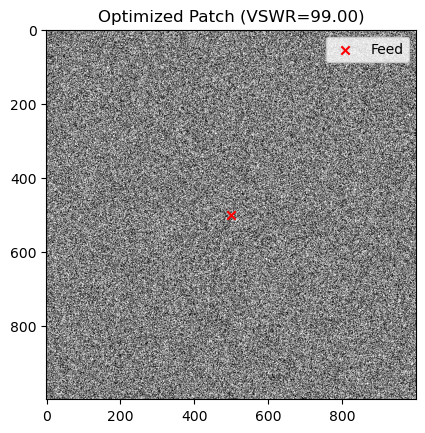

In [11]:
import numpy as np
import random
from scipy.ndimage import label
import necpp as PyNEC  # 使用 necpp 包 (与 PyNEC 接口兼容的实现)
from math import pi, log10

# ==========================================
# 1. 物理与仿真配置
# ==========================================
FREQ_MHZ = 2400.0
LAMBDA = 299.79 / FREQ_MHZ # meters
GRID_W = 60e-3  # 贴片区域总宽度 60mm
GRID_L = 60e-3  # 贴片区域总长度 60mm
HEIGHT = 5e-3   # 悬浮高度 5mm (空气介质)
WIRE_RAD = 0.5e-3 # 网格线半径

# 像素化网格分辨率
N_ROWS = 1000
N_COLS = 1000
# 每个像素的物理尺寸
DX = GRID_W / N_ROWS
DY = GRID_L / N_COLS

class NECOptimizer:
    def __init__(self, pop_size=20, mutation_rate=0.05):
        self.pop_size = pop_size
        self.mutation_rate = mutation_rate
        # 初始化种群：10x10 的 0/1 矩阵
        self.population = [np.random.randint(0, 2, (N_ROWS, N_COLS)) for _ in range(pop_size)]
        # 强制馈电点存在 (假设在网格中心)
        self.feed_pos = (N_ROWS//2, N_COLS//2)
        for ind in self.population:
            ind[self.feed_pos] = 1

    def _grid_to_nec_structure(self, grid, context):
        """
        核心函数：将 0/1 矩阵转换为 NEC 的 Wire Mesh 模型
        """
        geo = context.get_geometry()
        
        # 记录已创建的节点，避免重复
        # Node Map: (row, col) -> tag_id
        # 为了简化，我们直接生成 Segment
        
        tag_counter = 1
        feed_tag = -1
        
        # 1. 生成金属网格 (水平面 Z = HEIGHT)
        # 遍历所有像素，如果为 1，则画出它的边框/十字线
        # 为了简化模型量，我们采用 "Wire Grid" 策略：
        # 如果 grid[i,j]=1，则生成中心点到相邻点的连接线
        
        # 简单的 Mesh 策略：如果 grid[i,j] 是 1，
        # 则连接 (i,j) 到 (i+1, j) 和 (i, j+1) 如果它们也是 1
        
        pixel_centers = {} # (r, c) -> (x, y, z)
        
        # 计算所有激活像素的中心坐标
        for r in range(N_ROWS):
            for c in range(N_COLS):
                if grid[r, c] == 1:
                    x = (r - N_ROWS/2) * DX
                    y = (c - N_COLS/2) * DY
                    pixel_centers[(r,c)] = (x, y, HEIGHT)

        # 创建水平线段
        for r in range(N_ROWS):
            for c in range(N_COLS):
                if grid[r, c] == 1:
                    curr_pt = pixel_centers[(r,c)]
                    
                    # 向右连接
                    if c + 1 < N_COLS and grid[r, c+1] == 1:
                        next_pt = pixel_centers[(r, c+1)]
                        geo.wire(tag_counter, 1, curr_pt[0], curr_pt[1], curr_pt[2],
                                 next_pt[0], next_pt[1], next_pt[2], WIRE_RAD, 1.0, 1.0)
                        tag_counter += 1
                        
                    # 向下连接
                    if r + 1 < N_ROWS and grid[r+1, c] == 1:
                        next_pt = pixel_centers[(r+1, c)]
                        geo.wire(tag_counter, 1, curr_pt[0], curr_pt[1], curr_pt[2],
                                 next_pt[0], next_pt[1], next_pt[2], WIRE_RAD, 1.0, 1.0)
                        tag_counter += 1

        # 2. 生成馈电线 (Vertical Feed Probe)
        # 从 Ground (Z=0) 连接到 Feed Point (Z=HEIGHT)
        fx, fy = (self.feed_pos[0] - N_ROWS/2)*DX, (self.feed_pos[1] - N_COLS/2)*DY
        
        feed_tag = tag_counter
        # 生成垂直线，分 3 段以便计算准确
        geo.wire(feed_tag, 3, fx, fy, 0, fx, fy, HEIGHT, WIRE_RAD, 1.0, 1.0)
        
        context.geometry_complete(0)
        return feed_tag

    def calculate_vswr(self, grid):
        """
        调用 PyNEC 运行仿真
        """
        # 1. 连通性检查 (物理检查)
        # 如果馈电点是孤岛，直接返回最差适应度
        if not self._check_connectivity(grid):
            return 99.0

        try:
            context = PyNEC.nec_context()
            geo = context.get_geometry()
            
            # 2. 构建几何
            feed_tag = self._grid_to_nec_structure(grid, context)
            
            # 3. 设置地面 (Perfect Ground Plane)
            # gn_card(type, n_rad, 0, 0, 0, 0, 0, 0) -> type 1 = Perfect Ground
            context.gn_card(1, 0, 0, 0, 0, 0, 0, 0)
            
            # 4. 设置激励 (Excitation)
            # ex_card(type, tag, segment, 0, real, imag, 0, 0)
            # Voltage source (type 0) on feed_tag, segment 1 (bottom)
            context.ex_card(0, feed_tag, 1, 0, 1.0, 0.0, 0.0, 0.0)
            
            # 5. 设置频率
            context.fr_card(0, 1, FREQ_MHZ, 0)
            
            # 6. 运行仿真 (计算电流)
            context.xq_card(0) # Execute
            
            # 7. 提取阻抗 Z
            # 获取特定 tag, segment 的输入参数
            # PyNEC 的 API 获取阻抗比较隐晦，通常通过 lpt (line print) 或 extracting matrix
            # 这里简化：假设我们能获取 (API 随版本不同)
            # 实际上 PyNEC 提供了 get_input_parameters(idx)
            
            idx = context.get_input_parameters_index(feed_tag, 1) # Find index of feed
            z = context.get_input_impedance(idx) # Complex Z
            
            # 计算 VSWR (Z0 = 50 Ohm)
            z0 = 50.0
            rho = abs((z - z0) / (z + z0))
            if rho >= 1.0: return 99.0
            vswr = (1 + rho) / (1 - rho)
            
            return vswr
            
        except Exception as e:
            # 仿真失败 (几何错误/分段过少)
            # print(f"Sim Error: {e}")
            return 99.0

    def _check_connectivity(self, grid):
        """连通性检查"""
        if grid[self.feed_pos] == 0: return False
        labeled, n = label(grid)
        feed_label = labeled[self.feed_pos]
        # 只要金属总数 == 馈电点所在连通块的像素数，即为全连通
        return np.sum(grid) == np.sum(labeled == feed_label)

    def run_optimization(self, generations=20):
        print(f"--- 启动 PyNEC 拓扑优化 (Target: {FREQ_MHZ} MHz) ---")
        best_grid = None
        best_vswr = 99.0
        
        for gen in range(generations):
            scores = []
            for i, ind in enumerate(self.population):
                vswr = self.calculate_vswr(ind)
                scores.append(vswr)
                # 使用 <= 确保即使第一次为 99.0 也能记录最佳个体
                if vswr <= best_vswr:
                    best_vswr = vswr
                    best_grid = ind.copy()
                    print(f"Gen {gen} New Best! VSWR = {best_vswr:.3f}")
            
            # 简单的 GA 逻辑 (选择、变异)
            # 1. 排序
            sorted_indices = np.argsort(scores)
            self.population = [self.population[i] for i in sorted_indices]
            
            # 2. 保留前 20% 精英
            elite_count = int(self.pop_size * 0.2)
            new_pop = self.population[:elite_count]
            
            # 3. 繁殖
            while len(new_pop) < self.pop_size:
                # 随机变异
                parent = random.choice(self.population[:elite_count*2]).copy()
                
                # 变异逻辑：随机翻转像素
                mask = np.random.random(parent.shape) < self.mutation_rate
                parent[mask] = 1 - parent[mask]
                parent[self.feed_pos] = 1 # 保持馈电
                new_pop.append(parent)
            
            self.population = new_pop
            print(f"Gen {gen} Avg VSWR: {np.mean(scores):.3f}")
            
        return best_grid, best_vswr

# ==========================================
# 主运行块
# ==========================================
if __name__ == "__main__":
    try:
        opt = NECOptimizer(pop_size=10, mutation_rate=0.05) # 降低种群以加快演示
        best_shape, min_vswr = opt.run_optimization(generations=10)
        
        print("\n=== 优化完成 ===")
        print(f"最佳 VSWR: {min_vswr:.4f}")
        print("最佳拓扑形状 (1=金属, 0=空气):")
        print(best_shape)
        
        # 可选：绘制结果
        import matplotlib.pyplot as plt
        if best_shape is None:
            print("未能找到更优解，绘图已跳过。")
        else:
            plt.imshow(best_shape, cmap='binary')
            plt.title(f"Optimized Patch (VSWR={min_vswr:.2f})")
            plt.scatter(opt.feed_pos[1], opt.feed_pos[0], c='r', marker='x', label='Feed')
            plt.legend()
            plt.show()
        
    except ImportError:
        print("错误: 未找到 PyNEC 库。")
        print("请先编译安装 PyNEC (https://github.com/tmolteno/python-necpp)")
        print("或者在 Linux/Mac 环境下使用: pip install necpp")

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import necpp 
from scipy.optimize import differential_evolution

# ==========================================
# 1. 物理配置
# ==========================================
FREQ_MHZ = 2400.0
LAMBDA = 299.79 / FREQ_MHZ
MAX_RADIUS = 40e-3    # 最大半径 40mm (直径80mm区域)
MIN_RADIUS = 5e-3     # 最小半径 5mm (保证馈电点周围有金属)
HEIGHT = 5e-3         # 空气层高度
WIRE_RAD = 0.2e-3     # 网格线半径
NUM_ANGLES = 120       # 控制点数量 (120个点，每3度一个)

# 网格密度 (用于 NEC 内部填充)
GRID_DENSITY = 250   # 背景网格 25x25

class ContinuousAntennaOptimizer:
    def __init__(self):
        # 生成背景网格点 (用于裁剪)
        x = np.linspace(-MAX_RADIUS, MAX_RADIUS, GRID_DENSITY)
        y = np.linspace(-MAX_RADIUS, MAX_RADIUS, GRID_DENSITY)
        self.grid_x, self.grid_y = np.meshgrid(x, y)
        
        # 预先生成所有可能的水平和垂直线段
        self.all_segments = []
        
        # 水平线段
        for i in range(GRID_DENSITY):
            for j in range(GRID_DENSITY - 1):
                p1 = (self.grid_x[i, j], self.grid_y[i, j])
                p2 = (self.grid_x[i, j+1], self.grid_y[i, j+1])
                self.all_segments.append((p1, p2))
                
        # 垂直线段
        for i in range(GRID_DENSITY - 1):
            for j in range(GRID_DENSITY):
                p1 = (self.grid_x[i, j], self.grid_y[i, j])
                p2 = (self.grid_x[i+1, j], self.grid_y[i+1, j])
                self.all_segments.append((p1, p2))

    def generate_polygon(self, radii):
        """
        根据半径数组生成多边形顶点
        """
        angles = np.linspace(0, 2*np.pi, NUM_ANGLES, endpoint=False)
        # 闭合多边形：把第一个点加到最后
        polygon_verts = []
        for r, theta in zip(radii, angles):
            x = r * np.cos(theta)
            y = r * np.sin(theta)
            polygon_verts.append((x, y))
        
        return np.array(polygon_verts)

    def mesh_inside_polygon(self, polygon_verts):
        """
        核心算法：找出落在多边形内部的线段，生成 NEC 几何
        """
        # 使用 matplotlib.path 进行快速"点在多边形内"测试
        poly_path = Path(polygon_verts)
        
        valid_segments = []
        
        # 检查所有预设线段的中点是否在多边形内
        for p1, p2 in self.all_segments:
            mid_x = (p1[0] + p2[0]) / 2
            mid_y = (p1[1] + p2[1]) / 2
            
            # contains_point 返回 True/False
            if poly_path.contains_point((mid_x, mid_y)):
                valid_segments.append((p1, p2))
                
        return valid_segments

    def simulate_nec(self, radii):
        """
        运行 necpp 仿真
        """
        polygon_verts = self.generate_polygon(radii)
        segments = self.mesh_inside_polygon(polygon_verts)
        
        # 如果生成的网格太少（非物理），返回惩罚
        if len(segments) < 10:
            return 99.0

        try:
            context = necpp.nec_context()
            geo = context.get_geometry()
            
            tag = 1
            # 1. 生成金属网格 (Z = HEIGHT)
            for p1, p2 in segments:
                geo.wire(tag, 1, p1[0], p1[1], HEIGHT, p2[0], p2[1], HEIGHT, WIRE_RAD, 1.0, 1.0)
                tag += 1
            
            # 2. 生成馈电线 (Center Feed)
            # 从 (0,0,0) 到 (0,0,HEIGHT)
            feed_tag = tag
            geo.wire(feed_tag, 1, 0, 0, 0, 0, 0, HEIGHT, WIRE_RAD, 1.0, 1.0)
            
            context.geometry_complete(0)
            
            # 3. 设置地面和激励
            context.gn_card(1, 0, 0, 0, 0, 0, 0, 0) # Perfect Ground
            context.ex_card(0, feed_tag, 1, 0, 1.0, 0.0, 0.0, 0.0) # Voltage Source
            context.fr_card(0, 1, FREQ_MHZ, 0) # Freq
            
            # 4. 运行
            context.xq_card(0)
            
            # 5. 获取阻抗
            idx = context.get_input_parameters_index(feed_tag, 1)
            z = context.get_input_impedance(idx)
            
            # 计算 VSWR
            rho = abs((z - 50) / (z + 50))
            if rho >= 1.0: return 99.0
            return (1 + rho) / (1 - rho)
            
        except Exception:
            return 99.0

    def objective_function(self, radii):
        """
        优化目标函数
        """
        vswr = self.simulate_nec(radii)
        # 增加平滑度惩罚 (防止形状过于锯齿状)
        # 计算相邻半径的差值平方和
        smoothness_penalty = np.sum(np.diff(radii)**2) * 100 
        return vswr + smoothness_penalty

# ==========================================
# 运行优化
# ==========================================
if __name__ == "__main__":
    optimizer = ContinuousAntennaOptimizer()
    
    print(f"--- 开始径向样条拓扑优化 (Target: {FREQ_MHZ} MHz) ---")
    print(f"控制点数量: {NUM_ANGLES} (每 {360/NUM_ANGLES} 度一个)")
    
    # 差分进化算法 (Differential Evolution)
    # 变量范围: MIN_RADIUS 到 MAX_RADIUS
    bounds = [(MIN_RADIUS, MAX_RADIUS)] * NUM_ANGLES
    
    # 使用较少的迭代次数以便演示 (maxiter=5)
    # 实际使用请增加到 20-50
    result = differential_evolution(
        optimizer.objective_function, 
        bounds, 
        strategy='best1bin', 
        maxiter=10, 
        popsize=10, 
        disp=True,
        workers=1 # 多线程可能会导致 necpp 上下文冲突，建议单线程或使用 multiprocessing Pool
    )
    
    best_radii = result.x
    best_vswr = optimizer.simulate_nec(best_radii)
    
    print("\n=== 优化完成 ===")
    print(f"最佳 VSWR (近似): {best_vswr:.3f}")
    
    # ==========================================
    # 可视化结果
    # ==========================================
    # 生成多边形
    poly_verts = optimizer.generate_polygon(best_radii)
    # 闭合多边形用于绘图
    poly_verts_closed = np.vstack([poly_verts, poly_verts[0]])
    
    # 生成内部网格 (仿真用的模型)
    segments = optimizer.mesh_inside_polygon(poly_verts)
    
    plt.figure(figsize=(10, 5))
    
    # 子图1: 连续外轮廓 (制造用)
    plt.subplot(1, 2, 1)
    plt.plot(poly_verts_closed[:,0]*1000, poly_verts_closed[:,1]*1000, 'r-', linewidth=3, label='Cut Line')
    plt.fill(poly_verts_closed[:,0]*1000, poly_verts_closed[:,1]*1000, 'r', alpha=0.1)
    plt.scatter(0, 0, c='k', marker='x', label='Feed')
    plt.title("Optimized Continuous Shape (Manufacturing)")
    plt.xlabel("mm")
    plt.ylabel("mm")
    plt.axis('equal')
    plt.grid(True)
    plt.legend()
    
    # 子图2: NEC 网格模型 (仿真用)
    plt.subplot(1, 2, 2)
    for p1, p2 in segments:
        plt.plot([p1[0]*1000, p2[0]*1000], [p1[1]*1000, p2[1]*1000], 'b-', linewidth=0.5)
    plt.plot(poly_verts_closed[:,0]*1000, poly_verts_closed[:,1]*1000, 'r--', linewidth=1, alpha=0.5)
    plt.title(f"NEC Wire Grid Model (Simulated VSWR={best_vswr:.2f})")
    plt.axis('equal')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print("\n[制造数据]")
    print("控制点半径 (mm):")
    print(np.round(best_radii * 1000, 2))

--- 开始径向样条拓扑优化 (Target: 2400.0 MHz) ---
控制点数量: 120 (每 3.0 度一个)


KeyboardInterrupt: 